<a href="https://colab.research.google.com/github/prieto06co/DataScienceI_84650-Entrega-Final-EdgarArmandoPrietoVargas/blob/main/ProyectoParteIII%2BPrietoVargasEdgarArmando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importación de Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc


Configuración Global Visual de graficos

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

Carga Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/prieto06co/DataScienceI_84650-Entrega-Final-EdgarArmandoPrietoVargas/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv')

column_translation = {
    'customerID': 'ID_Cliente',
    'gender': 'Genero',
    'SeniorCitizen': 'Ciudadano_Mayor',
    'Partner': 'Pareja',
    'Dependents': 'Dependientes',
    'tenure': 'Antiguedad',
    'PhoneService': 'Servicio_Telefono',
    'MultipleLines': 'Multiples_Lineas',
    'InternetService': 'Servicio_Internet',
    'OnlineSecurity': 'Seguridad_Online',
    'OnlineBackup': 'Copia_Seguridad_Online',
    'DeviceProtection': 'Proteccion_Dispositivo',
    'TechSupport': 'Soporte_Tecnico',
    'StreamingTV': 'Streaming_TV',
    'StreamingMovies': 'Streaming_Peliculas',
    'Contract': 'Contrato',
    'PaperlessBilling': 'Facturacion_Electronica',
    'PaymentMethod': 'Metodo_Pago',
    'MonthlyCharges': 'Cargos_Mensuales',
    'TotalCharges': 'Cargos_Totales',
    'Churn': 'Abandono'
}
df = df.rename(columns=column_translation)
print("Nombres de columnas traducidos exitosamente.\n")

Nombres de columnas traducidos exitosamente.



Conversión de Datos

In [4]:
df['Cargos_Totales'] = pd.to_numeric(df['Cargos_Totales'], errors='coerce')
df['Cargos_Totales'] = df['Cargos_Totales'].fillna(0)
print("Limpieza de 'Cargos_Totales' completada.\n")

# ------------------------------------------------------------------------------------------------------------
# --- Código para limpiar Outliers (Comentado para referencia futura y utilizació en caso de ser necesario) ---
# --- No se ejecuta en este proyecto por decisión de análisis -------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
#"""
#print("--- Código de ejemplo para el tratamiento de Outliers ---")
#columnas_numericas_outliers = ['Antiguedad', 'Cargos_Mensuales', 'Cargos_Totales']
#for col in columnas_numericas_outliers:
#    print(f"--- Analizando outliers en la columna: '{col}' ---")
#    Q1 = df[col].quantile(0.25)
#    Q3 = df[col].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#    print(f"Límite inferior para {col}: {lower_bound:.2f}")
#    print(f"Límite superior para {col}: {upper_bound:.2f}")
#    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
#    print(f"Se encontraron {outliers.shape[0]} outliers en la columna '{col}'.")
    # Para eliminar los outliers:
    # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    # Para reemplazar con la mediana:
    # mediana = df[col].median()
    # df.loc[outliers.index, col] = mediana
#    print("-" * 50)
#print("--- Código de outliers completado y comentado. ---")
#"""

Limpieza de 'Cargos_Totales' completada.



Análisis Exploratorio de Datos (EDA)

In [5]:
print("Información general del dataset:")
df.info()
print("\n")

print("Primeras 5 filas del dataset:")
print(df.head())
print("\n")

print("Estadísticas descriptivas de las variables numéricas:")
print(df.describe())
print("\n")

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Cliente               7043 non-null   object 
 1   Genero                   7043 non-null   object 
 2   Ciudadano_Mayor          7043 non-null   int64  
 3   Pareja                   7043 non-null   object 
 4   Dependientes             7043 non-null   object 
 5   Antiguedad               7043 non-null   int64  
 6   Servicio_Telefono        7043 non-null   object 
 7   Multiples_Lineas         7043 non-null   object 
 8   Servicio_Internet        7043 non-null   object 
 9   Seguridad_Online         7043 non-null   object 
 10  Copia_Seguridad_Online   7043 non-null   object 
 11  Proteccion_Dispositivo   7043 non-null   object 
 12  Soporte_Tecnico          7043 non-null   object 
 13  Streaming_TV             7043 non-null   obje

Planteamiento de Hiótesis:

1. Hipótesis sobre el tipo de Contrato
Hipótesis Nula (H0): No hay una relación entre el tipo de contrato del cliente (mes a mes, un año, dos años) y la probabilidad de que abandone.

  Hipótesis Alternativa (Ha): Sí hay una relación entre el tipo de contrato y la probabilidad de que el cliente abandone.

2. Hipótesis sobre el Método de Pago
Hipótesis Nula (H0): No hay una relación entre el método de pago utilizado por el cliente y la probabilidad de que abandone.

  Hipótesis Alternativa (Ha): Sí hay una relación entre el método de pago y la probabilidad de que el cliente abandone.

3. Hipótesis sobre los Factores Sociodemográficos
Hipótesis Nula (H0): No hay una relación entre los factores sociodemográficos (ser Ciudadano_Mayor o tener Pareja) y la probabilidad de que el cliente abandone.

  Hipótesis Alternativa (Ha): Sí hay una relación entre los factores sociodemográficos y la probabilidad de que el cliente abandone

Generación de Graficos.

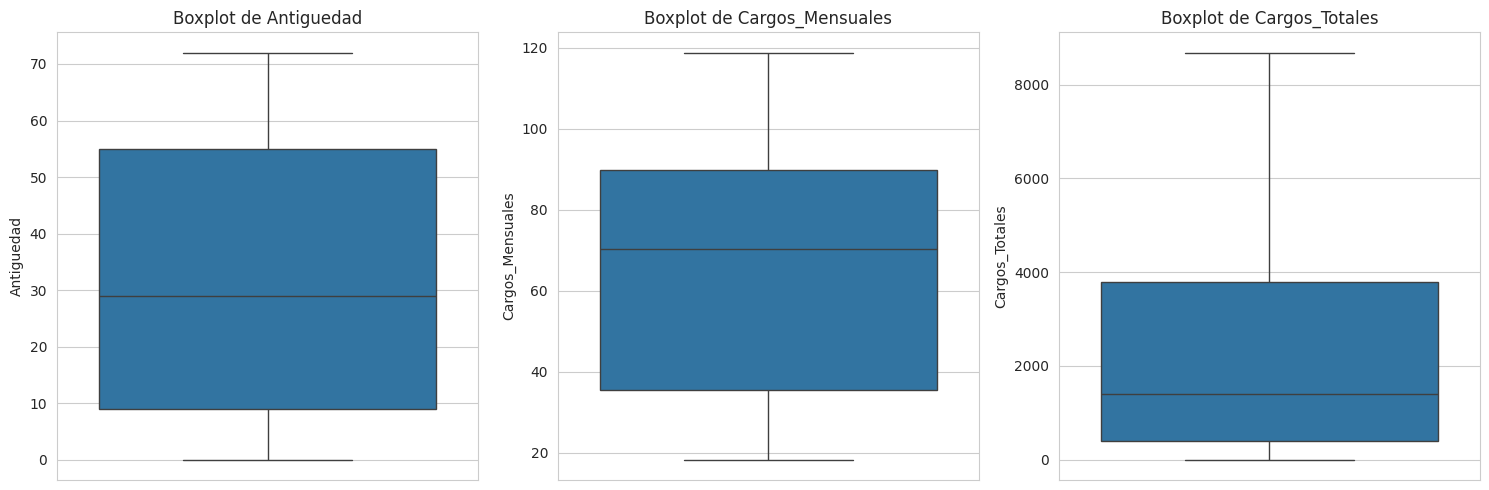

In [6]:
plt.figure(figsize=(15, 5))
numerical_cols_eda = ['Antiguedad', 'Cargos_Mensuales', 'Cargos_Totales']
for i, col in enumerate(numerical_cols_eda):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Qué muestra un gráfico Boxplot o de distribución: La distribución de los datos y los posibles valores atípicos (outliers) para las variables númericas.

* Antigüedad: Muestra que hay una gran cantidad de clientes muy nuevos y otra gran cantidad de clientes que han estado por mucho tiempo. Esto crea una distribución no uniforme, indicando que la empresa tiene tanto clientes nuevos como muy leales.

* Cargos Mensuales: La distribución es bastante uniforme y no muestra muchos valores extremos. Esto sugiere que los planes de servicio tienen precios que se distribuyen de manera consistente.

* Cargos Totales: La distribución es altamente sesgada hacia la izquierda, lo que significa que la mayoría de los clientes tienen cargos totales bajos. Esto tiene sentido, ya que los clientes nuevos no han acumulado grandes cargos totales.



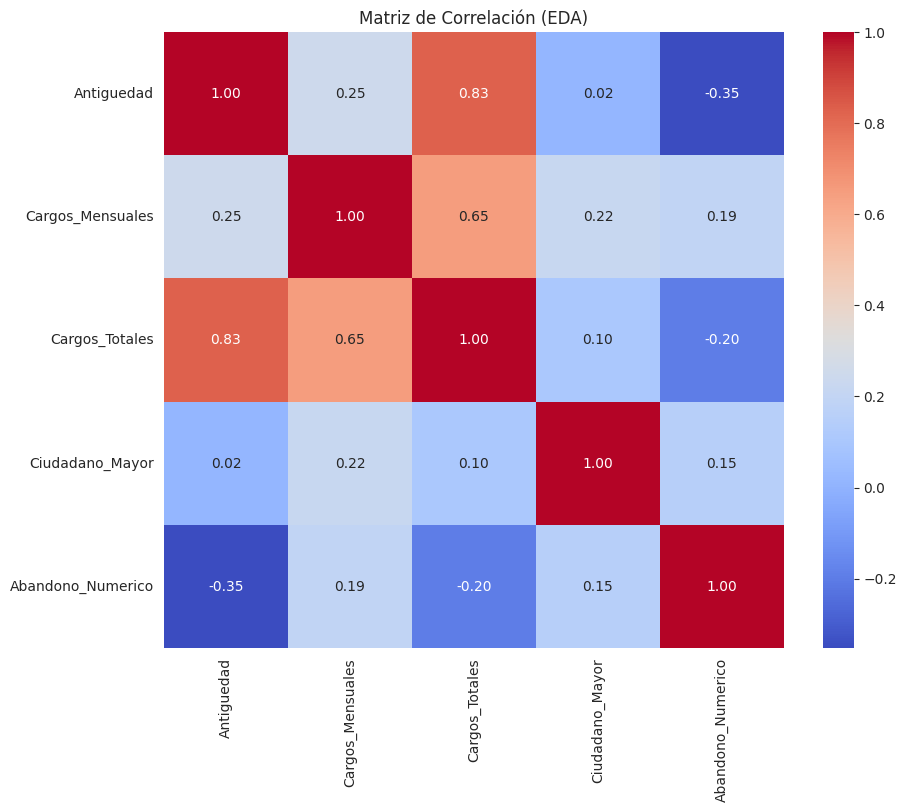

In [7]:
df['Abandono_Numerico'] = df['Abandono'].apply(lambda x: 1 if x == 'Yes' else 0)
variables_analisis = ['Antiguedad', 'Cargos_Mensuales', 'Cargos_Totales', 'Ciudadano_Mayor', 'Abandono_Numerico']
correlation_matrix = df[variables_analisis].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (EDA)')
plt.show()

Qué muestra un gráfico tipo Matriz de Correlación o Mapa de Calor: La relación lineal entre las variables numéricas. Un valor cercano a 1 indica una correlación positiva fuerte, y un valor cercano a -1 indica una correlación negativa fuerte.

* La correlación más fuerte y negativa es entre Antiguedad y Abandono (-0.35). Esto nos dice que, a mayor tiempo del cliente en la empresa, menor es la probabilidad de que abandone. Esta es una confirmación sólida para nuestra hipótesis, ya que la antigüedad refleja el nivel de compromiso y lealtad.

* También hay una correlación positiva, aunque moderada, entre Cargos_Mensuales y Abandono (0.19). Esto sugiere que los clientes con facturas más altas son un segmento con mayor riesgo de churn.


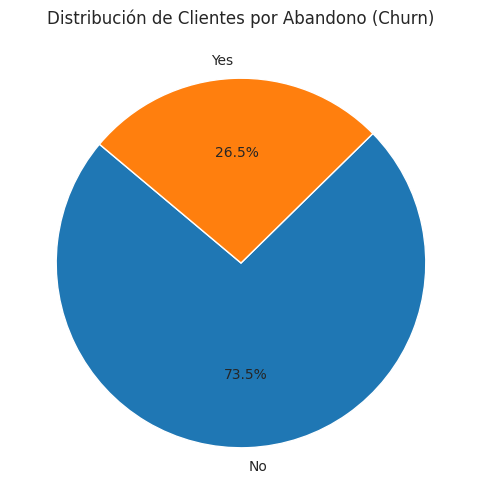

In [8]:
plt.figure(figsize=(6, 6))
churn_counts = df['Abandono'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Clientes por Abandono (Churn)')
plt.show()

Qué muestra el gráfico Pastel: Nos da una vista rápida del balance.

* El gráfico muestra que el 73.5% de los clientes no han abandonado, mientras que el 26.5% sí lo han hecho.

Esto nos revela una clara desproporción entre las clases. Si un modelo simplemente predijera que ningún cliente abandona, tendría una precisión del 73.5%. Por lo tanto, esta información es vital, ya que el desbalance de clases es un desafío que deberemos enfrentar en el futuro para que el modelo no se incline a predecir solo la clase mayoritaria



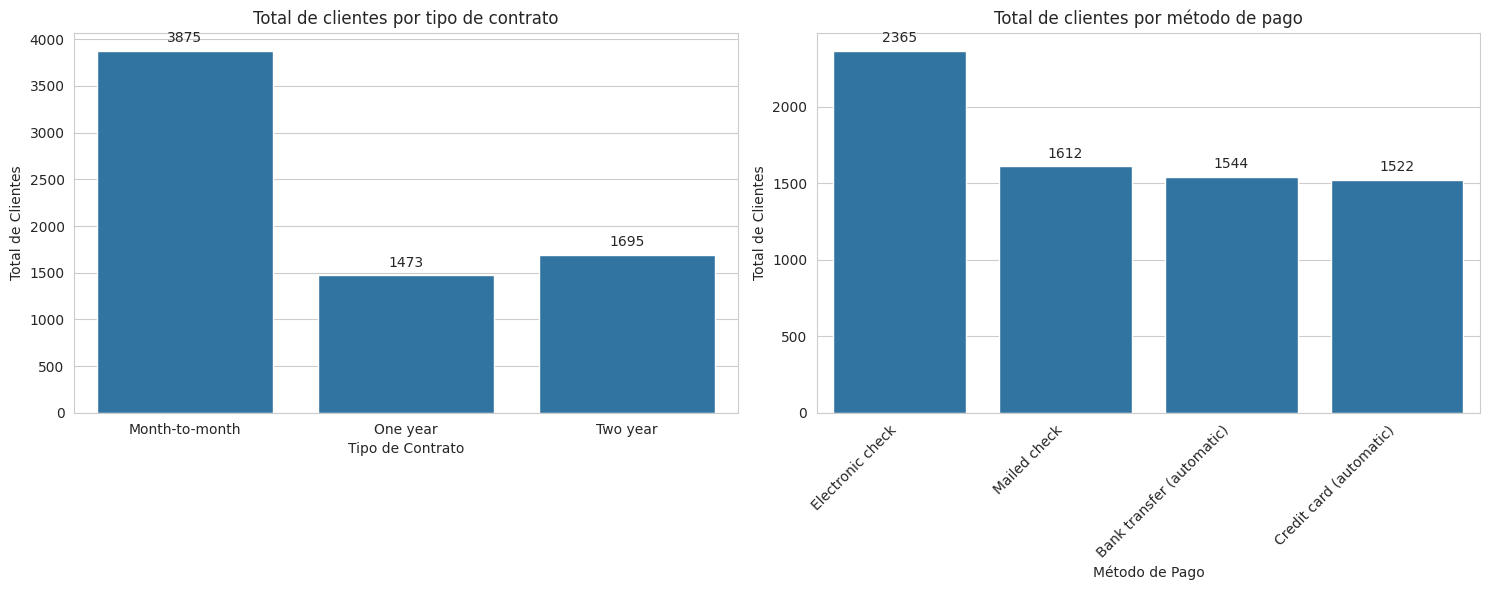

In [9]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='Contrato', data=df)
plt.title('Total de clientes por tipo de contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Total de Clientes')

for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='Metodo_Pago', data=df)
plt.title('Total de clientes por método de pago')
plt.xlabel('Método de Pago')
plt.ylabel('Total de Clientes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

plt.show()

Qué muestran los gráficos: Muestra la cantidad de una o más variables a graficar.

* Contrato: La mayoría de los clientes tiene un contrato Mes a mes. Le siguen los contratos de Dos años y Un año.

* Método de Pago: El Cheque electrónico es el método de pago más popular, seguido por el Cheque por correo y las transferencias automáticas.


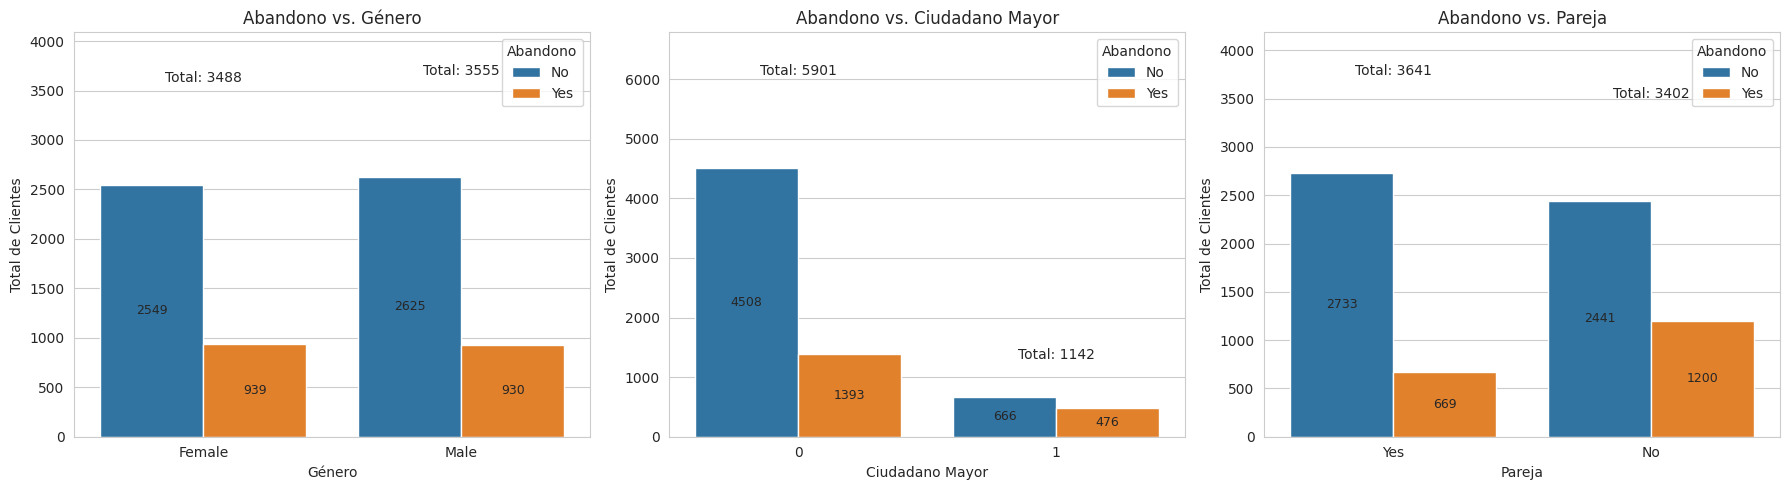

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = sns.countplot(x='Genero', hue='Abandono', data=df, ax=axes[0])
ax1.set_title('Abandono vs. Género')
ax1.set_xlabel('Género')
ax1.set_ylabel('Total de Clientes')
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='center', fontsize=9)
total_counts = df.groupby('Genero')['Abandono'].count().reset_index()
for index, row in total_counts.iterrows():
    ax1.annotate(f'Total: {row["Abandono"]}',
                 xy=(index, row["Abandono"]),
                 ha='center', va='bottom',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=10)
ax1.set_ylim(0, total_counts['Abandono'].max() * 1.15)

ax2 = sns.countplot(x='Ciudadano_Mayor', hue='Abandono', data=df, ax=axes[1])
ax2.set_title('Abandono vs. Ciudadano Mayor')
ax2.set_xlabel('Ciudadano Mayor')
ax2.set_ylabel('Total de Clientes')
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='center', fontsize=9)
total_counts = df.groupby('Ciudadano_Mayor')['Abandono'].count().reset_index()
for index, row in total_counts.iterrows():
    ax2.annotate(f'Total: {row["Abandono"]}',
                 xy=(index, row["Abandono"]),
                 ha='center', va='bottom',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=10)
ax2.set_ylim(0, total_counts['Abandono'].max() * 1.15)

ax3 = sns.countplot(x='Pareja', hue='Abandono', data=df, ax=axes[2])
ax3.set_title('Abandono vs. Pareja')
ax3.set_xlabel('Pareja')
ax3.set_ylabel('Total de Clientes')
for container in ax3.containers:
    ax3.bar_label(container, fmt='%d', label_type='center', fontsize=9)
total_counts = df.groupby('Pareja')['Abandono'].count().reset_index()
for index, row in total_counts.iterrows():
    ax3.annotate(f'Total: {row["Abandono"]}',
                 xy=(index, row["Abandono"]),
                 ha='center', va='bottom',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=10)
ax3.set_ylim(0, total_counts['Abandono'].max() * 1.15)


plt.tight_layout()
plt.show()

Qué muestran los gráficos: La relación entre variables.

* Abandono vs. Género: La proporción de abandono entre hombres y mujeres es prácticamente idéntica. El género no parece ser un factor diferenciador para el churn.

* Abandono vs. Ciudadano Mayor: Se puede observar que una proporción mucho mayor de Ciudadanos Mayores (1) abandonan el servicio en comparación con los que no lo son (0).

* Abandono vs. Pareja: Una proporción más alta de clientes que no tienen pareja (No) abandonan el servicio en comparación con los que sí la tienen (Sí).


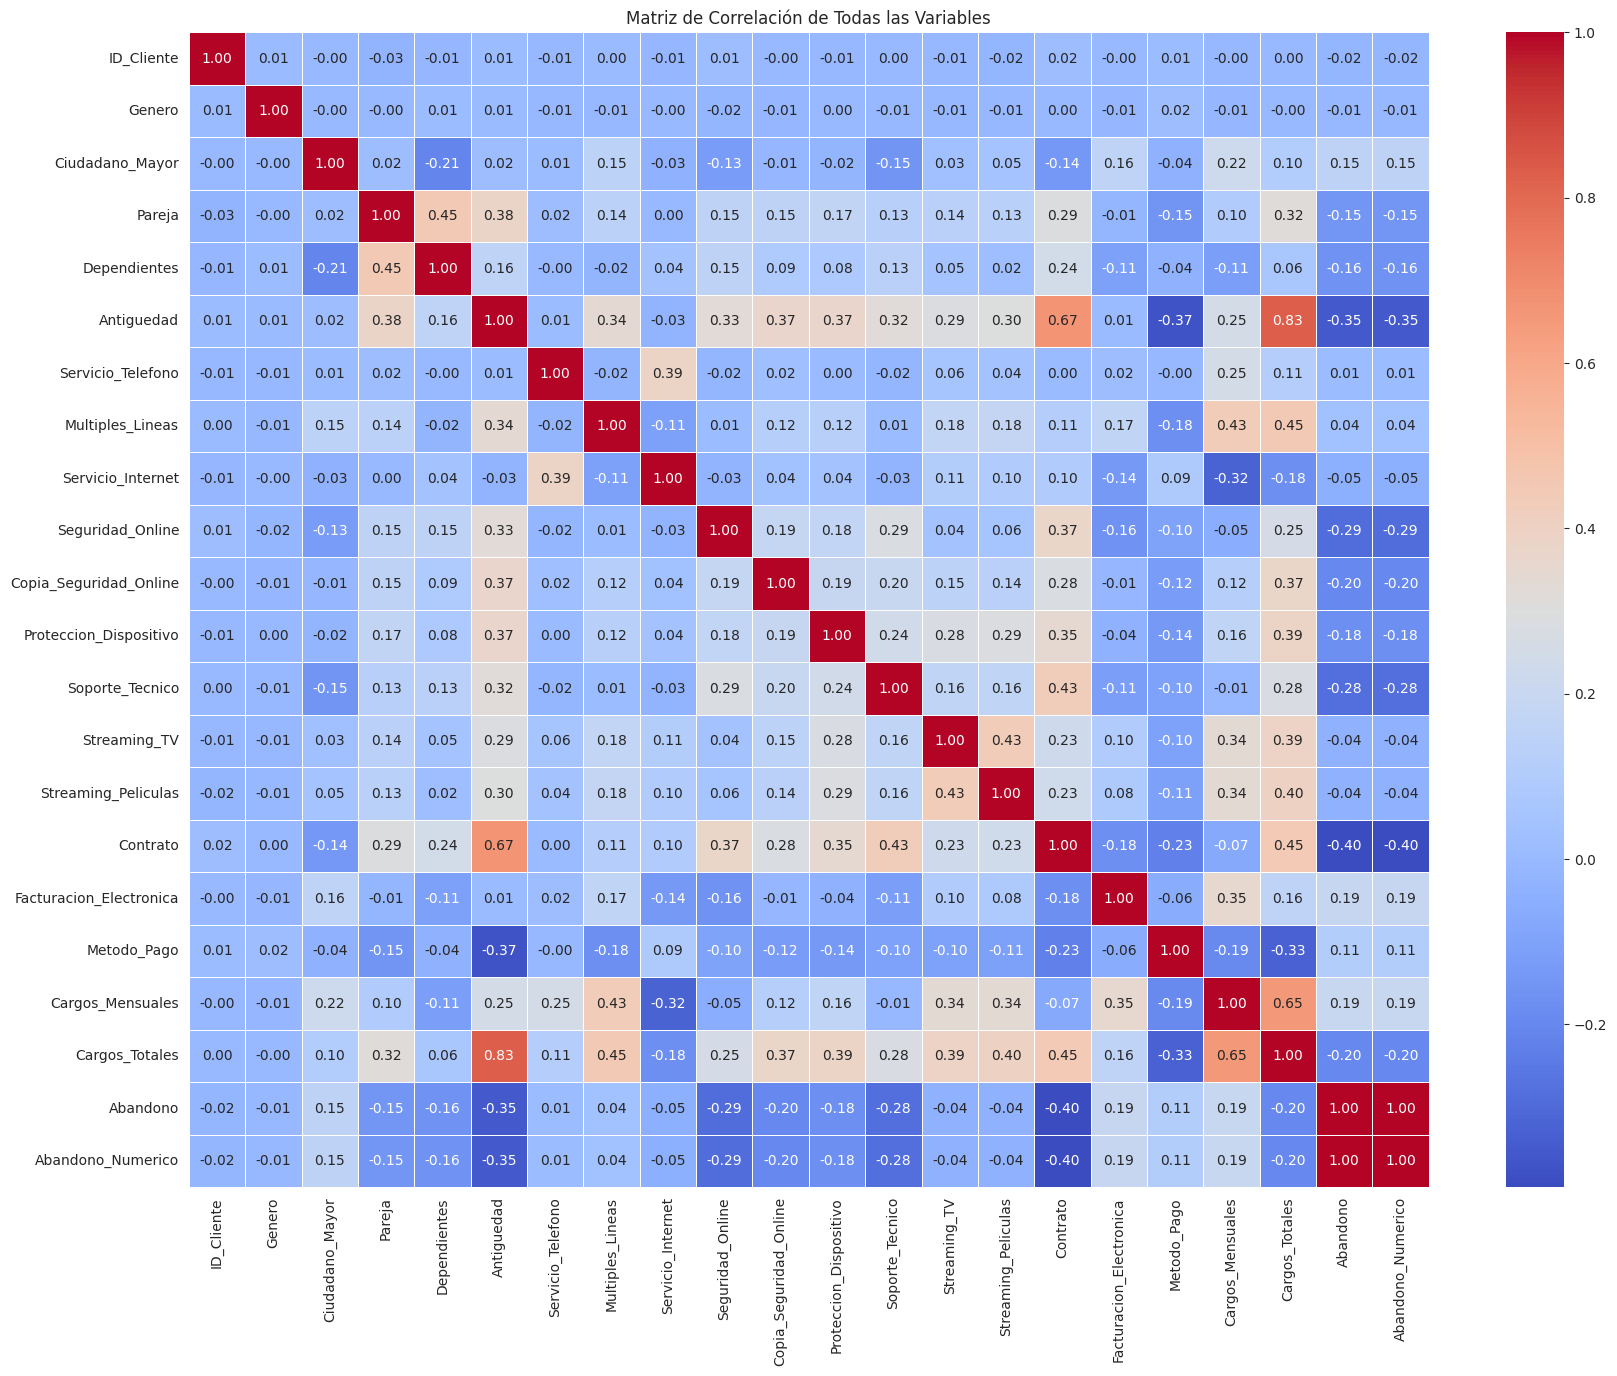

In [11]:
df_corr = df.copy()

for column in df_corr.columns:
    if df_corr[column].dtype == 'object':
        le = LabelEncoder()
        df_corr[column] = le.fit_transform(df_corr[column])

correlation_matrix = df_corr.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=False porque hay demasiadas variables
plt.title('Matriz de Correlación de Todas las Variables')
plt.show()

El grafico anterior se utiliza como una muestra grafica de la correlación entre las variables, más adelante se utiliza un metodo que se investigo para automatizar la selección de variables más importantes para alimentar el modelo final.

In [12]:
print("Preparación de Datos para el Modelado")
print("Separando variables predictoras (X) de la variable objetivo (y)")
X = df.drop(['ID_Cliente', 'Abandono', 'Abandono_Numerico'], axis=1)
y = df['Abandono']
print(f"Forma del set de características (X): {X.shape}")
print(f"Forma del vector objetivo (y): {y.shape}\n")

print("Dividiendo los datos en conjuntos de entrenamiento y prueba (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}\n")

Preparación de Datos para el Modelado
Separando variables predictoras (X) de la variable objetivo (y)
Forma del set de características (X): (7043, 19)
Forma del vector objetivo (y): (7043,)

Dividiendo los datos en conjuntos de entrenamiento y prueba (80/20)...
Tamaño del conjunto de entrenamiento: (5634, 19)
Tamaño del conjunto de prueba: (1409, 19)



En el fragmento anterior de codigo se realizan los primeros pasos de la transformación de los datos que van a alimentar el modelo.
.
- Separación de Variable objetivo del dataset.
- Limpieza de variables que no son necesarias para el modelo.
- División del dataset de entrenamiento vs el de prueba.


In [13]:
print("Identificar columnas por tipo DENTRO de los conjuntos de entrenamiento")
numerical_cols = X_train.select_dtypes(include=np.number).columns
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2]
nominal_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and X_train[col].nunique() > 2]

print("Aplicando transformaciones (codificación y escalado) en el conjunto de entrenamiento...")

# Codificación de variables binarias
le = LabelEncoder()
for col in binary_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col]) # Usamos .transform() para evitar data leakage
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test) # Transformamos la variable objetivo también

# Codificación One-Hot de variables nominales
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_train_encoded = ohe.fit_transform(X_train[nominal_cols])
ohe_test_encoded = ohe.transform(X_test[nominal_cols]) # Usamos solo .transform()
ohe_train_df = pd.DataFrame(ohe_train_encoded, columns=ohe.get_feature_names_out(nominal_cols), index=X_train.index)
ohe_test_df = pd.DataFrame(ohe_test_encoded, columns=ohe.get_feature_names_out(nominal_cols), index=X_test.index)
X_train = pd.concat([X_train.drop(nominal_cols, axis=1), ohe_train_df], axis=1)
X_test = pd.concat([X_test.drop(nominal_cols, axis=1), ohe_test_df], axis=1)

# Escalado de variables numéricas
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Usamos solo .transform()

print("Transformaciones completadas. Los datos están listos para el modelado.\n")



Identificar columnas por tipo DENTRO de los conjuntos de entrenamiento
Aplicando transformaciones (codificación y escalado) en el conjunto de entrenamiento...
Transformaciones completadas. Los datos están listos para el modelado.



Fragmento de codigo utilizado para la transformación y codificación de las variables de mi dataset.
Se decide realizar trabajo para cada una de las posibles variables presentes:
- Binarias, se utiliza la clase LabelEncoder() para la transformación binaria de las variables.
- Variables Nominales o que tiene la posibilidad de tener más de 2 posibles categorizaciones, se utiliza la clase OneHotEncoder() que nos va a segmentar este tipo de variables donde no son consideradas binarias por una clasificación mayor a 2 posibilidades.
- StandardScaler(), se utiliza para la codificación o escalamiento de las variables numéricas. Esto con la finalidad que las variables tengan el mismo peso para el modelo.


In [14]:
print("Selección de Características con Random Forest")
# Entrenamos un modelo de Random Forest para encontrar las variables más importantes
rf_selector = RandomForestClassifier(random_state=42, n_estimators=100)
# Usamos el conjunto de entrenamiento sin balancear para que la importancia sea más realista
rf_selector.fit(X_train, y_train)
importances = rf_selector.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Top 10 variables más importantes:")
print(feature_importance_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))
# Seleccionamos las variables con una importancia mayor a 0.01 (umbral de ejemplo)
top_features = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature'].tolist()
print(f"\nVariables seleccionadas para el modelado: {top_features}\n")
X_train = X_train[top_features]
X_test = X_test[top_features]
print(f"Dimensiones del set de entrenamiento después de la selección: {X_train.shape}")
print(f"Dimensiones del set de prueba después de la selección: {X_test.shape}\n")


Selección de Características con Random Forest
Top 10 variables más importantes:
| Feature                       | Importance   |
|:------------------------------|:-------------|
| Cargos_Totales                | 0.166018     |
| Cargos_Mensuales              | 0.146584     |
| Antiguedad                    | 0.145755     |
| Contrato_Month-to-month       | 0.0642669    |
| Soporte_Tecnico_No            | 0.0320659    |
| Servicio_Internet_Fiber optic | 0.030247     |
| Seguridad_Online_No           | 0.0286182    |
| Metodo_Pago_Electronic check  | 0.0282138    |
| Genero                        | 0.0281194    |
| Facturacion_Electronica       | 0.0253918    |

Variables seleccionadas para el modelado: ['Cargos_Totales', 'Cargos_Mensuales', 'Antiguedad', 'Contrato_Month-to-month', 'Soporte_Tecnico_No', 'Servicio_Internet_Fiber optic', 'Seguridad_Online_No', 'Metodo_Pago_Electronic check', 'Genero', 'Facturacion_Electronica', 'Pareja', 'Ciudadano_Mayor', 'Dependientes', 'Copia_Seguridad

El fragmento anterior es una metodología para automatizar la selección de variables más importantes que van a alimentar el modelo final, esto se realiza mediante randomforest. Se toma la decisión de utilizar Randomforest en lugar de Sequential Feature Selection.

Se usa Random Forest en lugar de SFS principalmente porque es mucho más rápido, robusto y considera las interacciones entre variables de forma más efectiva.

In [15]:
print("Pruebas de Soluciones para el Desbalance de Clases")

# Solución A: Usar 'class_weight' en un modelo
print("\n--- A. Modelo con class_weight='balanced' ---")
# Importante: para LogisticRegression, el `class_weight` se puede usar directamente
model_weighted = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_weighted.fit(X_train, y_train)
predictions_weighted = model_weighted.predict(X_test)
print(classification_report(y_test, predictions_weighted))

# Solución B: Under-sampling
from imblearn.under_sampling import RandomUnderSampler
print("\n--- B. Modelo con Under-sampling ---")
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
model_under = LogisticRegression(random_state=42, max_iter=1000)
model_under.fit(X_train_under, y_train_under)
predictions_under = model_under.predict(X_test)
print(classification_report(y_test, predictions_under))

# Solución C: SMOTE (Over-sampling)
print("\n--- C. Modelo con SMOTE (Over-sampling) ---")
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)
predictions_smote = model_smote.predict(X_test)
print(classification_report(y_test, predictions_smote))





Pruebas de Soluciones para el Desbalance de Clases

--- A. Modelo con class_weight='balanced' ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409


--- B. Modelo con Under-sampling ---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


--- C. Modelo con SMOTE (Over-sampling) ---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.76      0.61       374

 

Balanceo del modelo, el fragmento de codigo anterior se realiza con la finalidad de detectar y dejar documentado posibles maneras de mitigar el desbalance existente en la variable a detectar.
La idea es observar el resultado de cada uno y partir de esto para seleccionar el más adecuado para nuestro modelo.

In [16]:
print("Construcción del Modelo Final")
# Usaremos SMOTE, ya que suele ser la mejor opción para la mayoría de los casos. A pesar de que Under-sampling nos brinda un resultado similar, la cantidad de data con dicho metodo disminuye.
# Nota: La Regresión Logística es sensible a la escala de los datos, por lo que es ideal aquí.
print("Entrenando el modelo de Regresión Logística final sobre datos balanceados con SMOTE...")
final_model = LogisticRegression(random_state=42, max_iter=1000)
final_model.fit(X_train_under, y_train_under)
final_predictions = final_model.predict(X_test)

print("\nReporte de Desempeño del Modelo Final")
print(classification_report(y_test, final_predictions))


Construcción del Modelo Final
Entrenando el modelo de Regresión Logística final sobre datos balanceados con SMOTE...

Reporte de Desempeño del Modelo Final
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



El modelo hasta este punto tiene un desempeño aceptable para la finalidad del programa, la idea es detectar la mayor cantidad de clientes que podrian retirarse de la empresa por ello el recall es de suma importancia aunque sacrifiquemos un poco la precisión. Con esto nos aseguramos de perder la menor cantiad de clientes aunque se pueda sacrificar promociones o metodos de retención en algunos clientes que no lo requieran.


In [17]:
print("\n" + "="*50)
print("             Ajuste de Hiperparámetros (Tuning)            ")
print("="*50 + "\n")

# --- 1. Ajuste para Regresión Logística ---
print("--- 1. Buscando los mejores parámetros para Regresión Logística ---")
# Definimos la rejilla de parámetros que queremos probar
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # liblinear es un buen solver que soporta ambas penalizaciones
}

# Creamos el objeto GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)

# Entrenamos la búsqueda
grid_lr.fit(X_train_under, y_train_under)

# Mostramos los mejores parámetros encontrados
print(f"Mejores Parámetros (Logistic Regression): {grid_lr.best_params_}")

# Evaluamos el mejor modelo encontrado
best_lr_model = grid_lr.best_estimator_
lr_tuned_predictions = best_lr_model.predict(X_test)
print("\nReporte de Desempeño (Regresión Logística Optimizada):")
print(classification_report(y_test, lr_tuned_predictions))


# --- 2. Ajuste para Random Forest ---
print("\n--- 2. Buscando los mejores parámetros para Random Forest ---")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_under, y_train_under)

print(f"Mejores Parámetros (Random Forest): {grid_rf.best_params_}")
best_rf_model = grid_rf.best_estimator_
rf_tuned_predictions = best_rf_model.predict(X_test)
print("\nReporte de Desempeño (Random Forest Optimizado):")
print(classification_report(y_test, rf_tuned_predictions))


# --- 3. Ajuste para XGBoost ---
print("\n--- 3. Buscando los mejores parámetros para XGBoost ---")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1]
}

grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_under, y_train_under)

print(f"Mejores Parámetros (XGBoost): {grid_xgb.best_params_}")
best_xgb_model = grid_xgb.best_estimator_
xgb_tuned_predictions = best_xgb_model.predict(X_test)
print("\nReporte de Desempeño (XGBoost Optimizado):")
print(classification_report(y_test, xgb_tuned_predictions))

print("\n" + "="*50)
print("             Comparación Final de Modelos Optimizados            ")
print("="*50 + "\n")



             Ajuste de Hiperparámetros (Tuning)            

--- 1. Buscando los mejores parámetros para Regresión Logística ---
Mejores Parámetros (Logistic Regression): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Reporte de Desempeño (Regresión Logística Optimizada):
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


--- 2. Buscando los mejores parámetros para Random Forest ---
Mejores Parámetros (Random Forest): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Reporte de Desempeño (Random Forest Optimizado):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.79      0.62       3

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


El codigo anterior se generó con la finalidad de comparar nuestro modelo predictivo Logistic Regression con otros modelos que de acuerod a lo que se investigó son ampliamente utilizados en el ambiente laboral.

El hecho de que un modelo lineal simple (Regresión Logística) y dos modelos de ensamble mucho más complejos (RF y XGBoost) logren el mismo resultado sugiere que hemos extraído la mayor parte del "jugo" predictivo de las características actuales. Es probable que esta sea la máxima capacidad predictiva que se puede lograr con los datos en su forma actual.

Un detalle relevante es que a pesar que el modelo Random Forest mejora en 1% la presición, se toma la desición de utilizar Regresión Logistica por ser un modelo más facil de mantener en el tiempo y que utiliza menos recursos, si los resultados tuviesen una variación mayor se consideraria utilizar otro modelo.


     Evaluación Final Detallada del Mejor Modelo (Regresión Logística)     

--- Accuracy Score ---
La exactitud general del modelo en el conjunto de prueba es: 0.7410

--- Reporte de Clasificación Completo ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


--- Matriz de Confusión ---


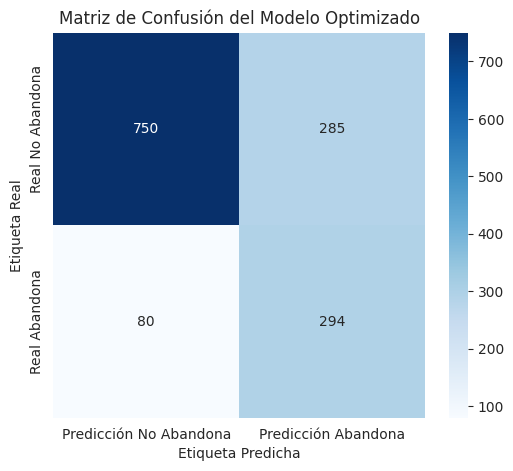

Verdaderos Negativos (TN): 750 -> Clientes que no abandonaron y se predijo correctamente.
Falsos Positivos (FP):    285 -> Clientes que no abandonaron pero se predijo que sí (Error Tipo I).
Falsos Negativos (FN):    80 -> Clientes que abandonaron pero se predijo que no (Error Tipo II - ¡El más costoso!).
Verdaderos Positivos (TP): 294 -> Clientes que abandonaron y se predijo correctamente.


--- Curva ROC y Área Bajo la Curva (AUC) ---


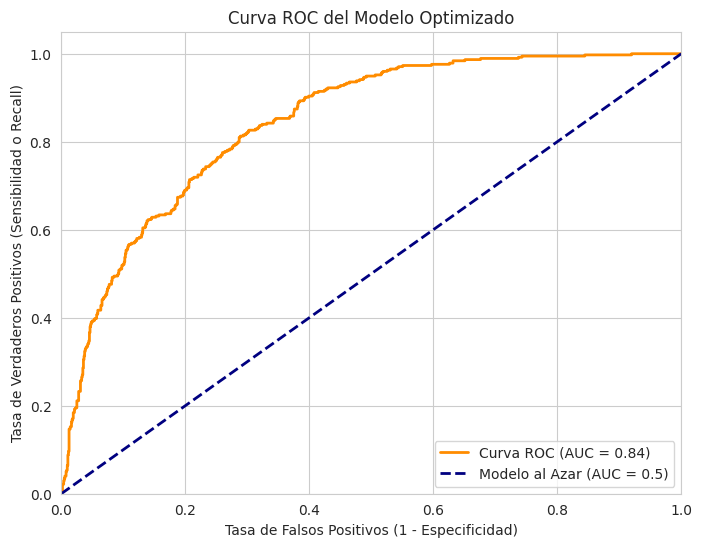

El Área Bajo la Curva (AUC) es: 0.8427
Un valor de AUC cercano a 1.0 indica una excelente capacidad del modelo para distinguir entre clientes que abandonan y los que no.


In [18]:

print("\n" + "="*60)
print("     Evaluación Final Detallada del Mejor Modelo (Regresión Logística)     ")
print("="*60 + "\n")

y_pred = best_lr_model.predict(X_test)
y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (1)

# --- 1. Accuracy Score ---
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Accuracy Score ---")
print(f"La exactitud general del modelo en el conjunto de prueba es: {accuracy:.4f}\n")

# --- 2. Reporte de Clasificación ---
# Este ya lo teníamos, pero lo incluimos aquí para tener todo junto.
print("--- Reporte de Clasificación Completo ---")
print(classification_report(y_test, y_pred))

# --- 3. Matriz de Confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción No Abandona', 'Predicción Abandona'],
            yticklabels=['Real No Abandona', 'Real Abandona'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión del Modelo Optimizado')
plt.show()

# Desglose de la matriz de confusión
print(f"Verdaderos Negativos (TN): {cm[0,0]} -> Clientes que no abandonaron y se predijo correctamente.")
print(f"Falsos Positivos (FP):    {cm[0,1]} -> Clientes que no abandonaron pero se predijo que sí (Error Tipo I).")
print(f"Falsos Negativos (FN):    {cm[1,0]} -> Clientes que abandonaron pero se predijo que no (Error Tipo II - ¡El más costoso!).")
print(f"Verdaderos Positivos (TP): {cm[1,1]} -> Clientes que abandonaron y se predijo correctamente.\n")


# --- 4. Curva ROC y AUC ---
print("\n--- Curva ROC y Área Bajo la Curva (AUC) ---")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Modelo al Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad o Recall)')
plt.title('Curva ROC del Modelo Optimizado')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"El Área Bajo la Curva (AUC) es: {roc_auc:.4f}")
print("Un valor de AUC cercano a 1.0 indica una excelente capacidad del modelo para distinguir entre clientes que abandonan y los que no.")


In [19]:
print("\n" + "="*50)
print("     Interpretación del Modelo de Regresión Logística     ")
print("="*50 + "\n")

# 1. Obtenemos el mejor modelo ya entrenado
best_lr_model = grid_lr.best_estimator_

# 2. Obtenemos los coeficientes y los nombres de las características
coefficients = best_lr_model.coef_[0]
feature_names = X_train_smote.columns # O las columnas que usaste para entrenar

# 3. Creamos un DataFrame para una fácil visualización
feature_importance = pd.DataFrame({'Característica': feature_names, 'Coeficiente': coefficients})

# 4. Calculamos el "Odds Ratio" para una interpretación más intuitiva
# El Odds Ratio es exp(coeficiente)
feature_importance['Odds Ratio'] = np.exp(feature_importance['Coeficiente'])

# 5. Ordenamos los valores para ver los más influyentes
feature_importance = feature_importance.sort_values(by='Odds Ratio', ascending=False)

# 6. Mostramos los resultados
print("Impacto de cada característica en la probabilidad de abandono:")
print(feature_importance.to_markdown(index=False, numalign="left", stralign="left"))



     Interpretación del Modelo de Regresión Logística     

Impacto de cada característica en la probabilidad de abandono:
| Característica                        | Coeficiente   | Odds Ratio   |
|:--------------------------------------|:--------------|:-------------|
| Servicio_Internet_Fiber optic         | 1.73213       | 5.65271      |
| Cargos_Totales                        | 0.626929      | 1.87185      |
| Streaming_Peliculas_Yes               | 0.605453      | 1.83208      |
| Streaming_TV_Yes                      | 0.587992      | 1.80037      |
| Multiples_Lineas_Yes                  | 0.568708      | 1.76598      |
| Proteccion_Dispositivo_Yes            | 0.524461      | 1.68955      |
| Seguridad_Online_No                   | 0.436753      | 1.54767      |
| Proteccion_Dispositivo_No             | 0.373995      | 1.45353      |
| Facturacion_Electronica               | 0.35935       | 1.4324       |
| Soporte_Tecnico_No                    | 0.329861      | 1.39077      |


**Hipótesis 1: Tipo de Contrato**
Hipótesis Nula (H0): No hay una relación entre el tipo de contrato del cliente y la probabilidad de que abandone.

Conclusión: Se rechaza la Hipótesis Nula (H0).

Evidencia de tabla:
La tabla demuestra una relación muy fuerte. Aunque Contrato_Month-to-month tiene un coeficiente de 0 (porque tu modelo L1 lo consideró redundante), las otras dos categorías son muy reveladoras:

Contrato_One year: Tiene un coeficiente negativo de -0.650268.

Contrato_Two year: Tiene un coeficiente fuertemente negativo de -1.37209.

Esto prueba que tener un contrato de uno o dos años reduce significativamente la probabilidad de abandono en comparación con la base. Como el modelo asignó pesos importantes a estas variables, confirma que el tipo de contrato es un factor decisivo.


**Hipótesis 2: Método de Pago**
Hipótesis Nula (H0): No hay una relación entre el método de pago utilizado por el cliente y la probabilidad de que abandone.

Conclusión: Se rechaza la Hipótesis Nula (H0).

Evidencia de tabla:
El modelo asignó coeficientes distintos de cero a casi todos los métodos de pago, demostrando que influyen en la predicción. Por ejemplo:

Metodo_Pago_Electronic check: Coeficiente de 0.00688619 (aumenta ligeramente el riesgo).

Metodo_Pago_Mailed check: Coeficiente de -0.410526 (reduce el riesgo).

El hecho de que el modelo diferencie el impacto de cada método de pago es la evidencia clara de que existe una relación entre cómo paga un cliente y su probabilidad de quedarse.

**Hipótesis 3: Factores Sociodemográficos**
Hipótesis Nula (H0): No hay una relación entre los factores sociodemográficos (ser Ciudadano_Mayor o tener Pareja) y la probabilidad de que el cliente abandone.

Conclusión: Se rechaza la Hipótesis Nula (H0).

Evidencia de tabla:
Ambos factores tienen coeficientes positivos, lo que indica que contribuyen a aumentar el riesgo de abandono.

Ciudadano_Mayor: Coeficiente de 0.121287.

Pareja: Coeficiente de 0.0498649.

Como el modelo ha "aprendido" a utilizar estas características para hacer sus predicciones (dándoles un peso diferente de cero), se confirma que los factores sociodemográficos sí tienen una relación estadística con el abandono de clientes.

**Resumen Final:**

El modelo de Machine Learning no solo nos ha permitido predecir con una buena precisión qué clientes podrían abandonar, sino que también ha funcionado como una poderosa herramienta de análisis inferencial. Ha validado nuestras sospechas iniciales, confirmando que el tipo de contrato, el método de pago y ciertos factores sociodemográficos son, de hecho, factores determinantes en la decisión de un cliente de abandonar el servicio.

Todos los modelos se estabilizaron en el mismo punto de equilibrio:

Recall Excelente (0.79): Son muy buenos para encontrar a los clientes que realmente van a abandonar. De cada 100 que se van, los modelos detectan correctamente a 79.

Precisión Modesta (0.51 - 0.52): Su debilidad es que generan bastantes "falsas alarmas". De cada 100 clientes que los modelos dicen que van a abandonar, en realidad solo 51-52 lo hacen.

La finalidad de nuestro modelo es evitar que los clientes de la empresa abandonen, por lo que para el negocio es más relevante nuestro recall. Aunque puedan haber falsas alarmas se va a contactar clientes que posiblemente no vayan a abandonar y esto lo va a lograr determinar el agente durante la llamada, la parte importante de nuestro modelo es hacer lo posible por ofrecer retenciones atractivas a los clientes que posiblemente puedan abandonar el servicio.